# Uncompensated system

First we determine the closed-loop characteristics of the uncompensated (i.e. original) system.
Using the transfer function
$$
T(s) = \frac{A/T}{s^2 + (1/T)s + A/T} = \frac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2}.
$$
we can see that $\omega_n = \sqrt{A/T}$ and $\zeta = \frac{1}{2T\omega_n}$.

This gives us various system constants, such as 
$$
T_s = \frac{4}{\zeta\omega_n} \text{ and OS} = e^{-( \zeta \pi / \sqrt{1-\zeta^2} )}.
$$

In [2]:
using ControlSystems

# system constants
A, T = 8.719908846328394, 7.34749253427418
ωₙ = √(A/T)
ζ = 1/(2*T*ωₙ)
Tₛ = 4/(ζ*ωₙ)
OS = e^(-( ζ*π / √(1-ζ^2) ))
println("A:\t$A\nT:\t$T\nζ:\t$ζ\nωₙ:\t$ωₙ\nTₛ:\t$Tₛ\nOS:\t$OS")

# now we plot the step response
s = tf("s")
TF = tf([ωₙ^2], [1, 2*ζ*ωₙ, ωₙ^2])
stepplot(TF, 120)

A:	8.719908846328394
T:	7.34749253427418
ζ:	0.062466109056976506
ωₙ:	1.0893975539232872
Tₛ:	58.77994027419344
OS:	0.8214969410522049
if !Plots.is_installed("PyPlot")
    Pkg.add("PyPlot")
end
withenv("PYTHON" => "") do
    Pkg.build("PyPlot")
end

# now restart julia!




INFO: To do a standard install of pyplot, copy and run this:



LoadError: [91mPyError (ccall(@pysym(:PyImport_ImportModule), PyPtr, (Cstring,), name)

The Python package matplotlib.colors could not be found by pyimport. Usually this means
that you did not install matplotlib.colors in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the matplotlib.colors module, you can
use `pyimport_conda("matplotlib.colors", PKG)`, where PKG is the Anaconda
package the contains the module matplotlib.colors, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <type 'exceptions.ImportError'>
ImportError('cannot import name cbook',)
  File "/home/amisi/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/__init__.py", line 124, in <module>
    from . import cbook
[39m

# Problem description

Now we have the plant above, and we intend to build a controller which will:
* ensure low steady-state error
* reduce settling time until $T_s \le 15$ seconds
* reduce overshoot until OS $\le 0.15$
* increase loop gain if possible

Choosing OS $\le 0.15$ yields 
$ \zeta = -\frac{\ln(0.15)}{ \sqrt{ π^2 + \ln{0.15^2} } } $. Since our inputs are (by assumption?) steps and the open loop system is Type 1 we needn't worry about steady-state error.

In [11]:
ζₙ = -log(0.15)/√(π^2 + (log(0.15)^2))
Tₛₙ = 4/(ζₙ*ωₙ)
OSₙ = e^(-( ζₙ*π / √(1-ζₙ^2) ))
println("ζₙ:\t$ζₙ\nTₛₙ:\t$Tₛₙ\nOSₙ:\t$OSₙ")

ζₙ:	0.5169308662051556
Tₛₙ:	7.1029888125757905
OSₙ:	0.14999999999999997


Thus clearly increasing $\zeta$ as such will suffice for reducing the settling time and
overshoot: the loop gain and steady-state error remain to be resolved.

# Adding lead compensation

The root locus for the uncompensated system is shown below.

Poles: [-0.06805042640977547 - 1.0872700538318385im] and [-0.06805042640977547 + 1.0872700538318385im].



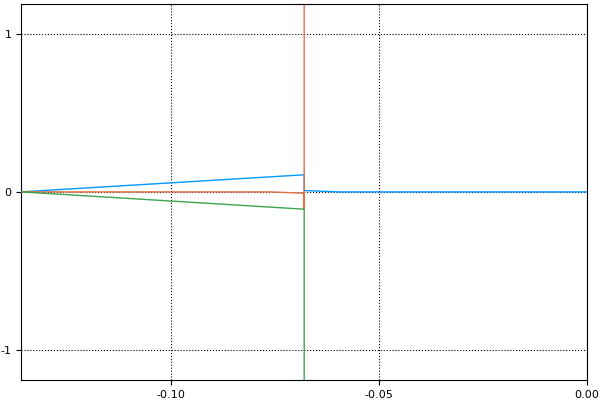

In [12]:
P = tf([A/T], [1, 1/T, 0])
z,p,k = zpkdata(TF)
p1, p2 = p[:1]
println("Poles: [$p1] and [$p2].")
rlplant = rlocus(P, linspace(1e-6, 1.2, 10000))
#Plots.plot!(map(real, [p1, p2]), map(imag, [p1,p2]) , m=(8,:x), c=:orange, line=:scatter)
#display(rlplant)
#Plots.savefig(rlplant, "rlplant.svg")
#pzmap(system::ControlSystems.LTISystem, args...; kwargs...) at /home/amisi/.julia/v0.5/ControlSystems/src/plotting.jl:480(P)


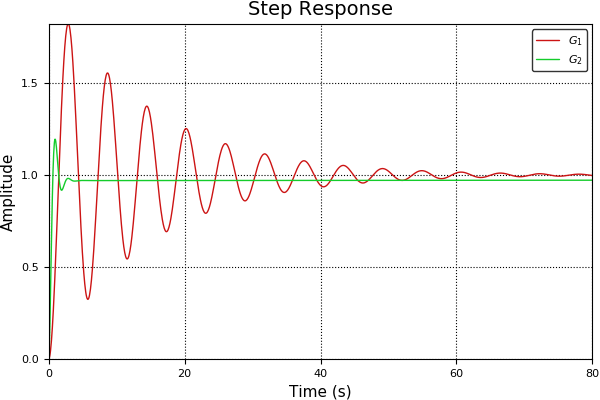

K: 12.668812809593813


(10.67488309534355,0.001,2.9113907758190956,0.5169308662051556)

In [18]:
ζ = -log(0.15)/√(π^2 + (log(0.15)^2))
φ = acos(ζ)
σ = 2
ω = σ*tan(φ)
s = -σ + im*ω
zc = 0.001
θ₁ = π - atan(ω/(σ - zc))
θ₂ = π - φ
θ₃ = π - atan(ω/(σ - abs(p1)))
θ₄ = π + θ₁ - θ₂ - θ₃
pc = ω/tan(θ₄) + σ

#zc,pc = (1/(50e3*22e-6)),(1/(180e-3))

K = real(-s*(s+1/T)*(s+pc)/(s+zc))
K₀ = K*T/A
G = K₀ * tf([1, zc], [1, pc])
Tₛ = 4/(σ)



display(stepplot([TF, feedback(G*P)], 80))
println("K: $K")
K₀,zc,pc,ζ